<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Anomalies Removal with the Isolation Forest  (IF)
</p>

In [2]:
# === Libraries ===
import math                                       # For mathematical operations
import matplotlib.pyplot as plt                   # For plotting and visualizations
import numpy as np                                # For numerical operations
import pandas as pd                               # For data manipulation and analysis
import seaborn as sns                             # For enhanced data visualizations
from sklearn.ensemble import IsolationForest      # For anomaly detection in datasets
from sklearn.preprocessing import StandardScaler  # For standardizing features

# For inline plots within Jupyter Notebook
%matplotlib inline                                

In [3]:
# Load Data and display it.
data = pd.read_csv('../all_data_files/visually_cleaned_df.csv')
data

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 11:01:08.336258+00:00,ED0,541.0,49.34,0.46,299.70,24.57,-52.0,13.2,9,868.1,81.0,108.0,0.246784,10,0,0,69.26,-65.403045,-52.203045
1,2024-09-26 11:02:08.387851+00:00,ED0,539.0,49.34,0.39,299.69,24.57,-48.0,8.5,9,867.5,82.0,109.0,0.246784,10,0,0,65.26,-57.073822,-48.573822
2,2024-09-26 11:03:08.309590+00:00,ED0,540.0,49.33,0.80,299.77,24.59,-48.0,12.8,8,867.3,83.0,110.0,0.133632,10,0,0,65.26,-61.022142,-48.222142
3,2024-09-26 11:04:08.368448+00:00,ED0,537.0,49.28,0.71,299.70,24.62,-48.0,8.0,8,868.5,84.0,111.0,0.133632,10,0,0,65.26,-56.638920,-48.638920
4,2024-09-26 11:05:08.405529+00:00,ED0,537.0,49.34,0.56,299.69,24.63,-49.0,11.0,8,867.9,85.0,112.0,0.133632,10,0,0,66.26,-60.331956,-49.331956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994884,2025-07-01 04:53:31.594125+00:00,ED5,476.0,43.33,1.62,323.02,28.68,-99.0,7.5,7,867.1,327286.0,359155.0,0.071936,40,2,2,116.26,-107.210819,-99.710819
1994885,2025-07-01 04:54:31.649429+00:00,ED5,479.0,43.35,1.98,323.02,28.68,-102.0,7.5,7,868.1,327287.0,359156.0,0.071936,40,2,2,119.26,-110.210819,-102.710819
1994886,2025-07-01 04:55:31.693487+00:00,ED5,485.0,43.30,1.87,323.02,28.66,-98.0,7.2,7,867.7,327288.0,359157.0,0.071936,40,2,2,115.26,-105.957462,-98.757462
1994887,2025-07-01 04:56:31.742859+00:00,ED5,486.0,43.30,1.91,322.99,28.68,-97.0,7.8,7,867.3,327289.0,359158.0,0.071936,40,2,2,114.26,-105.466832,-97.666832


In [4]:
# Calculate the maximum and minimum for all columns
summary = pd.DataFrame({
    'Max': data.max(),
    'Min': data.min()
})

# Displaying the table
display(summary)

,Max,Min
time,2025-07-01 04:57:42.144552+00:00,2024-09-26 11:00:52.541686+00:00
device_id,ED5,ED0
co2,1993.0,386.0
humidity,60.19,13.96
pm25,637.71,0.0
pressure,347.57,286.91
temperature,45.32,13.74
rssi,-28.0,-128.0
snr,25.2,-24.5
SF,12,7


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Data Preprocessing/Cleaning
</p>

In [6]:
# Use ISO8601 format for parsing
data['time'] = pd.to_datetime(data['time'], format='ISO8601', errors='coerce', utc=True)
# Capture rows before excluding SF11 and SF12
rows_before_sf_exclusion = len(data)

# Exclude SF11 and SF12 datapoints
data = data[~data['SF'].isin([11, 12])]

# Capture rows after excluding SF11 and SF12
rows_after_sf_exclusion = len(data)

# Calculate removed rows and percentage
rows_removed_sf = rows_before_sf_exclusion - rows_after_sf_exclusion
percentage_removed_sf = (rows_removed_sf / rows_before_sf_exclusion) * 100

# Display SF exclusion results
print("---- SF11 and SF12 Exclusion ----")
print(f"Rows before exclusion: {rows_before_sf_exclusion}")
print(f"Rows removed: {rows_removed_sf} ({percentage_removed_sf:.2f}%)\n")

# ---- Convert Object Columns to Numeric Where Possible ----
numeric_columns = data.select_dtypes(include=['object', 'string']).columns
for col in numeric_columns:
    if col != 'device_id':
        data[col] = pd.to_numeric(data[col], errors='coerce')

# ---- Reset the Index to Have 'time' as a Column Again ----
data.reset_index(drop=True, inplace=True)

# ---- Identify and Remove Rows with NaN or Inf Values ----
total_rows = len(data)

# Identify rows with any NaN values
rows_with_nan = data.isnull().any(axis=1)

# Identify rows with any Inf or -Inf values
rows_with_inf = data.isin([np.inf, -np.inf]).any(axis=1)

# Combine conditions to identify problematic rows
rows_with_issues = rows_with_nan | rows_with_inf

# Count the number of affected rows
affected_rows = rows_with_issues.sum()

# Calculate the percentage of affected rows
affected_percentage = (affected_rows / total_rows) * 100

# Display the results
print("---- NaN and Inf Removal ----")
print(f"Total number of rows: {total_rows}")
print(f"Rows with NaN or Inf: {affected_rows} ({affected_percentage:.2f}%)\n")

# ---- Dropping Affected Rows ----

# Drop the affected rows and reset the index
data = data[~rows_with_issues].reset_index(drop=True)

# Final number of rows after NaN and Inf removal
final_rows_after_nan_inf = len(data)
final_percentage_after_nan_inf = (final_rows_after_nan_inf / total_rows) * 100

print("---- Data After NaN and Inf Removal ----")
print(f"Rows after NaN and Inf removal: {final_rows_after_nan_inf} ({final_percentage_after_nan_inf:.2f}%)\n")

# ---- Remove Rows with Zero in Specific Columns ----

# Define the columns to check for zeros
columns_to_check = ['co2', 'humidity', 'pressure', 'temperature']

# Ensure that the columns exist in the DataFrame
missing_columns = [col for col in columns_to_check if col not in data.columns]
if missing_columns:
    print(f"Warning: The following columns are missing and will be skipped: {missing_columns}")
    columns_to_check = [col for col in columns_to_check if col in data.columns]

# Capture rows before zero exclusion
rows_before_zero_exclusion = len(data)

# Identify rows where any of the specified columns have a value of zero
rows_with_zero = (data[columns_to_check] == 0).any(axis=1)

# Count the number of rows to be removed
rows_removed_zero = rows_with_zero.sum()
percentage_removed_zero = (rows_removed_zero / rows_before_zero_exclusion) * 100

# Remove the rows with zeros in specified columns
data = data[~rows_with_zero].reset_index(drop=True)

# Capture rows after zero exclusion
rows_after_zero_exclusion = len(data)

# Display zero exclusion results
print("---- Zero Value Exclusion ----")
print(f"Rows before zero exclusion: {rows_before_zero_exclusion}")
print(f"Rows removed due to zero in {columns_to_check}: {rows_removed_zero} ({percentage_removed_zero:.2f}%)\n")

# ---- Final Number of Rows After All Cleaning Steps ----
final_rows = len(data)
final_percentage = (final_rows / rows_before_sf_exclusion) * 100

print("---- Final Cleaned Data ----")
print(f"Rows after all cleaning steps: {final_rows} ({final_percentage:.2f}%)\n")

# ---- Summary of All Removals ----

# Total rows removed from SF exclusion, NaN/Inf removal, and zero value removal
total_rows_removed = rows_removed_sf + affected_rows + rows_removed_zero
total_percentage_removed = (total_rows_removed / rows_before_sf_exclusion) * 100

print("---- Summary of Data Cleaning ----")
print(f"Total rows before any cleaning: {rows_before_sf_exclusion}")
print(f"Total rows removed: {total_rows_removed} ({total_percentage_removed:.2f}%)")
print(f"Total rows after cleaning: {final_rows} ({final_percentage:.2f}%)")


---- SF11 and SF12 Exclusion ----
Rows before exclusion: 1994889
Rows removed: 564083 (28.28%)

---- NaN and Inf Removal ----
Total number of rows: 1430806
Rows with NaN or Inf: 843 (0.06%)

---- Data After NaN and Inf Removal ----
Rows after NaN and Inf removal: 1429963 (99.94%)

---- Zero Value Exclusion ----
Rows before zero exclusion: 1429963
Rows removed due to zero in ['co2', 'humidity', 'pressure', 'temperature']: 0 (0.00%)

---- Final Cleaned Data ----
Rows after all cleaning steps: 1429963 (71.68%)

---- Summary of Data Cleaning ----
Total rows before any cleaning: 1994889
Total rows removed: 564926 (28.32%)
Total rows after cleaning: 1429963 (71.68%)


In [7]:
# Calculate the maximum and minimum for all columns
summary = pd.DataFrame({
    'Max': data.max(),
    'Min': data.min()
})

# Displaying the table
display(summary)

,Max,Min
time,2025-07-01 04:57:42.144552+00:00,2024-09-26 11:00:52.541686+00:00
device_id,ED5,ED0
co2,1993.0,386.0
humidity,60.19,13.99
pm25,637.71,0.0
pressure,347.57,286.91
temperature,45.32,13.74
rssi,-29.0,-128.0
snr,25.2,-19.0
SF,10,7


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Box Plots before removing anomalies
</p>

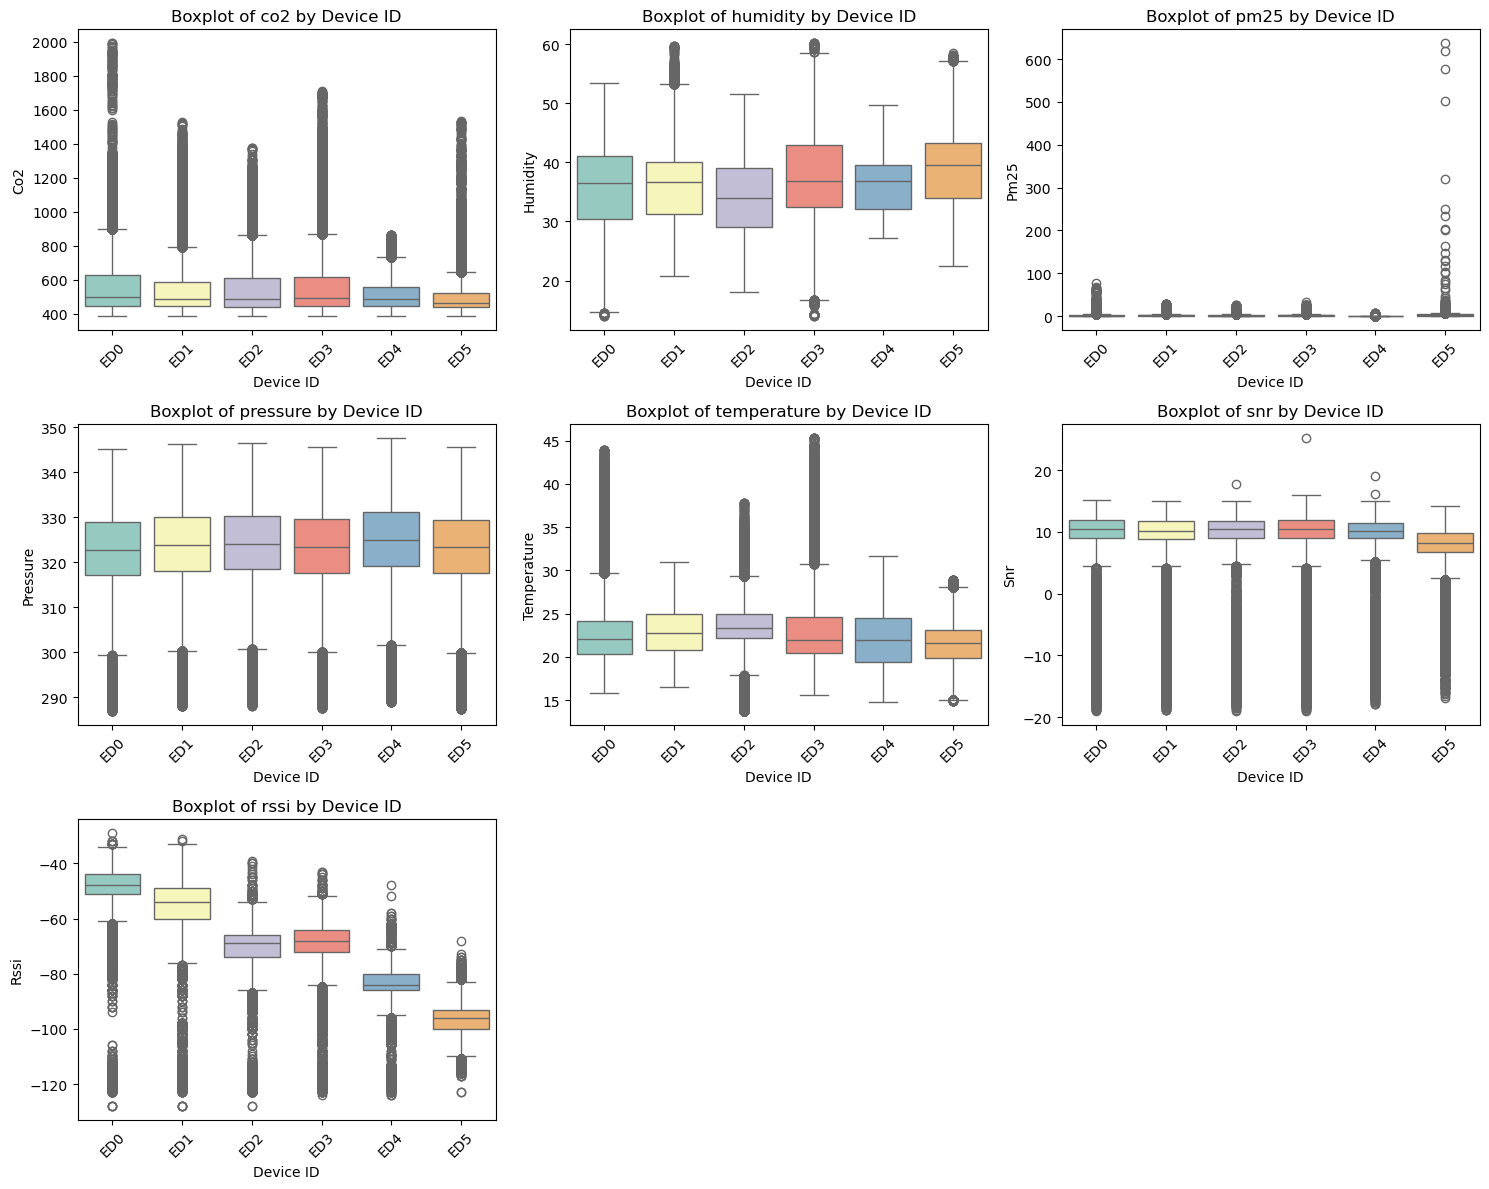

In [9]:
# Define the desired columns
desired_columns = ['co2', 'humidity', 'pm25', 'pressure', 'temperature', 'snr', 'rssi']
available_columns = [col for col in desired_columns if col in data.columns]

if not available_columns:
    raise ValueError("None of the specified columns are present in the DataFrame.")

# Warn if some columns are missing
missing_columns = set(desired_columns) - set(available_columns)
if missing_columns:
    print(f"Warning: The following columns are not in the DataFrame and will be skipped: {missing_columns}")

# Select the specified numeric columns
numeric_cols = data[available_columns].select_dtypes(include=['float64', 'int64']).columns.tolist()

if not numeric_cols:
    raise ValueError("None of the specified columns are numeric.")

# Define the desired order for device_id
desired_order = ['ED0', 'ED1', 'ED2', 'ED3', 'ED4', 'ED5']

# Ensure 'device_id' is a categorical type with the specified order
# Use .loc to avoid SettingWithCopyWarning
data.loc[:, 'device_id'] = pd.Categorical(
    data['device_id'], 
    categories=desired_order, 
    ordered=True
)

# Determine the number of plots
num_vars = len(numeric_cols)
cols = 3  # Number of columns in the subplot grid
rows = math.ceil(num_vars / cols)

# Set the overall figure size
plt.figure(figsize=(cols * 5, rows * 4))

# Iterate over each numeric column and create a subplot
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.boxplot(
        x='device_id', 
        y=col, 
        hue='device_id',          # Assign 'device_id' to hue
        data=data, 
        order=desired_order,
        palette="Set3",           # Customize the color palette
        legend=False              # Remove the redundant legend
    )
    plt.title(f'Boxplot of {col} by Device ID')
    plt.xlabel('Device ID')
    plt.ylabel(col.capitalize())  # Capitalize for better readability
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Applying IF to remove anomalies in the dataset.
</p>

In [11]:
# Parameters
contamination_level = 0.01  # Adjust as needed
window_size = 8  # Rolling window length for feature engineering

# Features used for anomaly detection
features = ['co2', 'humidity', 'pm25', 'pressure', 'temperature', 'rssi', 'snr']

def detect_anomalies_per_device(device_data, contamination=contamination_level):
    # Sort by 'time' to maintain chronological order
    device_data = device_data.sort_values('time').reset_index(drop=True)
    
    # Ensure all features are numeric
    for col in features:
        device_data[col] = pd.to_numeric(device_data[col], errors='coerce')
    
    # Drop rows with NaN in base features
    device_data.dropna(subset=features, inplace=True)
    if device_data.shape[0] < 1:
        print("Not enough data to process for this device.")
        return pd.DataFrame(), {}
    
    # Temporal Feature Engineering: Rolling means and differences
    for f in features:
        # Rolling mean
        device_data[f + '_mean' + str(window_size)] = device_data[f].rolling(window=window_size, min_periods=1).mean()
        # First-order difference
        device_data[f + '_diff'] = device_data[f].diff()
    
    # After engineering, some rows at the start may have NaN due to diff calculation
    device_data.dropna(inplace=True)
    if device_data.shape[0] < 1:
        print("Not enough data after feature engineering.")
        return pd.DataFrame(), {}
    
    # Final feature set (original + engineered)
    engineered_features = features + [f + '_mean' + str(window_size) for f in features] + [f + '_diff' for f in features]
    X = device_data[engineered_features]
    
    # Standard Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Isolation Forest
    iso_forest = IsolationForest(
        n_estimators=100,
        max_samples='auto',
        contamination=contamination,
        random_state=42,
        n_jobs=-1
    )
    iso_forest.fit(X_scaled)
    
    # Predict anomalies
    device_data['anomaly_score'] = iso_forest.decision_function(X_scaled)
    device_data['anomaly'] = iso_forest.predict(X_scaled)
    device_data['anomaly_label'] = device_data['anomaly'].map({1: 'Normal', -1: 'Anomaly'})
    
    # Statistics
    total_points = len(device_data)
    anomalies_count = (device_data['anomaly'] == -1).sum()
    anomaly_percentage = (anomalies_count / total_points) * 100
    
    stats = {
        'device_id': device_data['device_id'].iloc[0],
        'total_points': total_points,
        'anomalies_detected': anomalies_count,
        'anomaly_percentage': anomaly_percentage
    }
    
    return device_data, stats

# Usage with our dataset
device_ids = data['device_id'].unique()
results = []
device_stats = []

for device_id in device_ids:
    print(f"Processing data for: {device_id}")
    device_data = data[data['device_id'] == device_id]
    
    if device_data.empty:
        print(f"No data for device {device_id}. Skipping.")
        continue
    
    device_analyzed, stats = detect_anomalies_per_device(device_data, contamination=contamination_level)
    
    if not device_analyzed.empty:
        results.append(device_analyzed)
        device_stats.append(stats)
    else:
        print(f"No valid data to process for device {device_id}.")

if results:
    data_with_anomalies = pd.concat(results, ignore_index=True)
    anomalies = data_with_anomalies[data_with_anomalies['anomaly'] == -1]
    cleaned_data = data_with_anomalies[data_with_anomalies['anomaly'] == 1]
    
    stats_df = pd.DataFrame(device_stats)
    total_points_all = stats_df['total_points'].sum()
    anomalies_detected_all = stats_df['anomalies_detected'].sum()
    anomaly_percentage_all = (anomalies_detected_all / total_points_all) * 100

    print(f"Total data points processed: {total_points_all}")
    print(f"Total anomalies detected: {anomalies_detected_all}")
    print(f"Overall anomaly percentage: {anomaly_percentage_all:.2f}%")
else:
    print("No valid data was processed for any device.")

stats_df

Processing data for: ED0
Processing data for: ED1
Processing data for: ED2
Processing data for: ED3
Processing data for: ED4
Processing data for: ED5
Total data points processed: 1429957
Total anomalies detected: 14303
Overall anomaly percentage: 1.00%


,device_id,total_points,anomalies_detected,anomaly_percentage
0,ED0,238101,2381,0.999996
1,ED1,235202,2353,1.000417
2,ED2,239304,2394,1.000401
3,ED3,235953,2360,1.000199
4,ED4,235314,2354,1.000365
5,ED5,246083,2461,1.000069


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Box Plots after removing anomalies
</p>

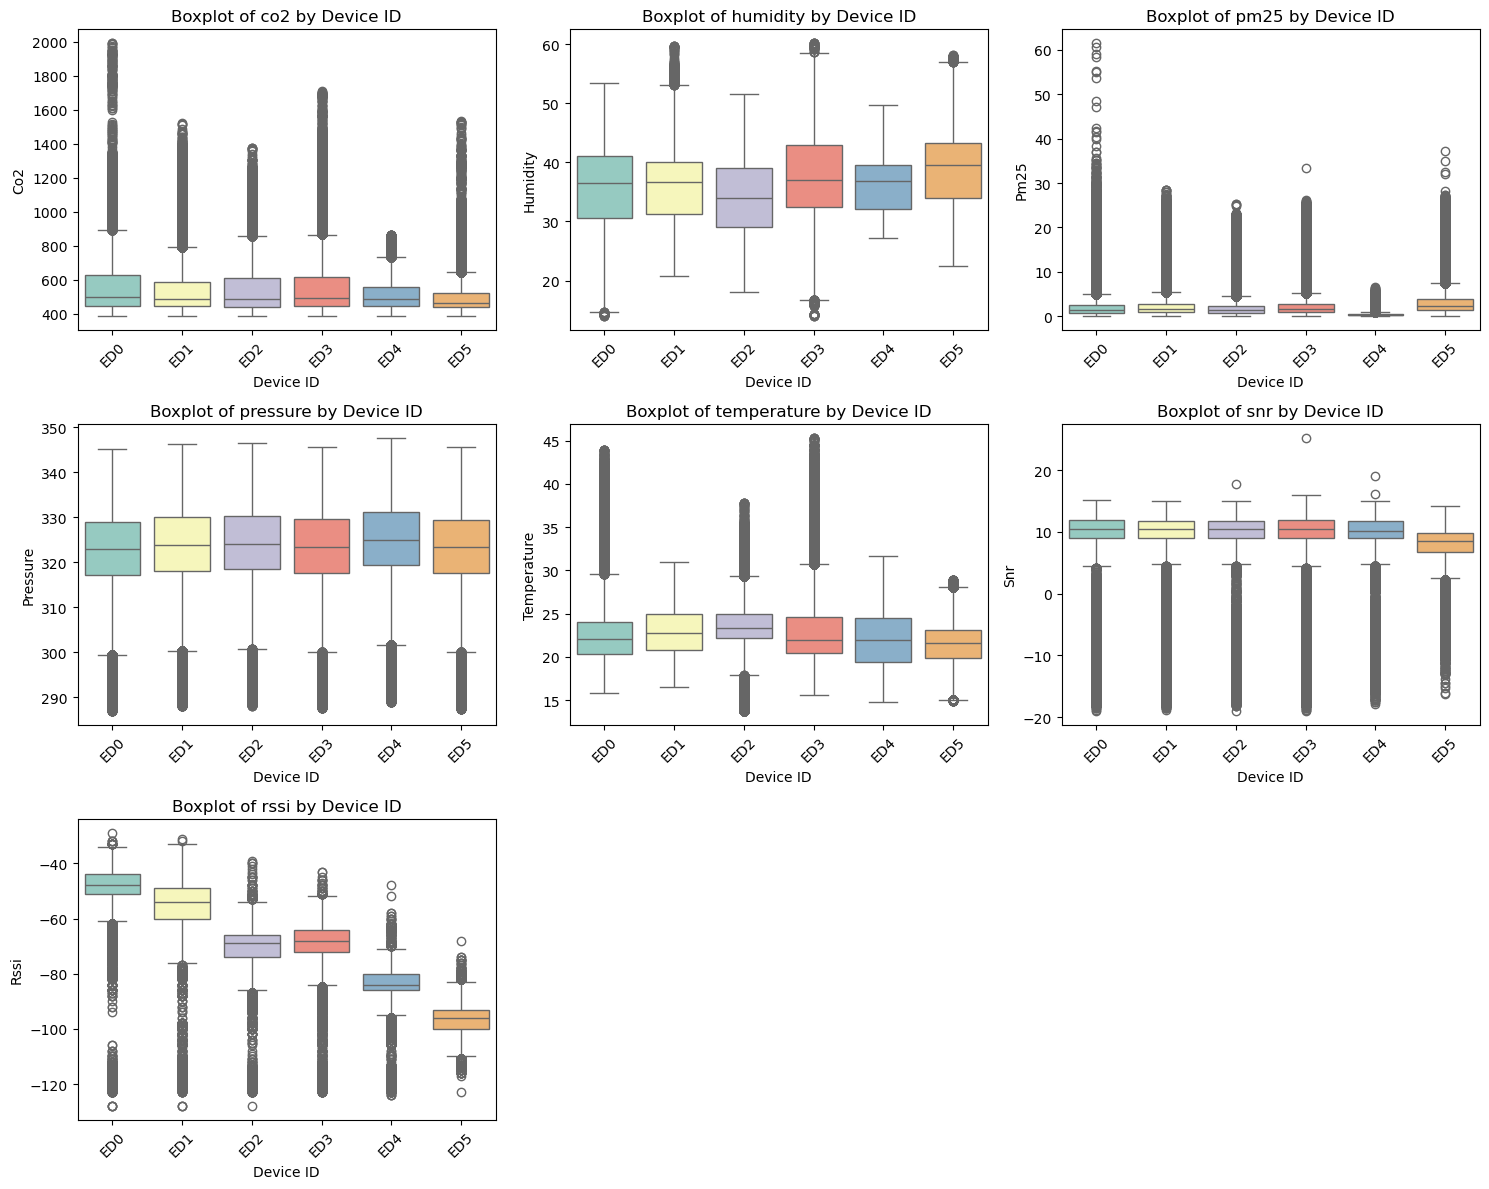

In [13]:
# Define the desired columns
desired_columns = ['co2', 'humidity', 'pm25', 'pressure', 'temperature', 'snr', 'rssi']
available_columns = [col for col in desired_columns if col in cleaned_data.columns]

if not available_columns:
    raise ValueError("None of the specified columns are present in the DataFrame.")

# Warn if some columns are missing
missing_columns = set(desired_columns) - set(available_columns)
if missing_columns:
    print(f"Warning: The following columns are not in the DataFrame and will be skipped: {missing_columns}")

# Select the specified numeric columns
numeric_cols = cleaned_data[available_columns].select_dtypes(include=['float64', 'int64']).columns.tolist()

if not numeric_cols:
    raise ValueError("None of the specified columns are numeric.")

# Define the desired order for device_id
desired_order = ['ED0', 'ED1', 'ED2', 'ED3', 'ED4', 'ED5']

# Ensure 'device_id' is a categorical type with the specified order
# Use .loc to avoid SettingWithCopyWarning
cleaned_data.loc[:, 'device_id'] = pd.Categorical(
    cleaned_data['device_id'], 
    categories=desired_order, 
    ordered=True
)

# Determine the number of plots
num_vars = len(numeric_cols)
cols = 3  # Number of columns in the subplot grid
rows = math.ceil(num_vars / cols)

# Set the overall figure size
plt.figure(figsize=(cols * 5, rows * 4))

# Iterate over each numeric column and create a subplot
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.boxplot(
        x='device_id', 
        y=col, 
        hue='device_id',          # Assign 'device_id' to hue
        data=cleaned_data, 
        order=desired_order,
        palette="Set3",           # Customize the color palette
        legend=False              # Remove the redundant legend
    )
    plt.title(f'Boxplot of {col} by Device ID')
    plt.xlabel('Device ID')
    plt.ylabel(col.capitalize())  # Capitalize for better readability
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [14]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1415654 entries, 0 to 1429956
Data columns (total 37 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   time               1415654 non-null  datetime64[ns, UTC]
 1   device_id          1415654 non-null  object             
 2   co2                1415654 non-null  float64            
 3   humidity           1415654 non-null  float64            
 4   pm25               1415654 non-null  float64            
 5   pressure           1415654 non-null  float64            
 6   temperature        1415654 non-null  float64            
 7   rssi               1415654 non-null  float64            
 8   snr                1415654 non-null  float64            
 9   SF                 1415654 non-null  int64              
 10  frequency          1415654 non-null  float64            
 11  f_count            1415654 non-null  float64            
 12  p_count            

In [15]:
# List of columns to retain
columns_to_retain = [
    "time", "device_id", "co2", "humidity", "pm25", "pressure", "temperature", 
    "rssi", "snr", "SF", "frequency", "f_count", "p_count", "toa", "distance", 
    "c_walls", "w_walls", "exp_pl", "n_power", "esp"
]

# Ensure only the desired columns are retained
cleaned_data = cleaned_data[columns_to_retain]
cleaned_data = cleaned_data.sort_values('time')

In [16]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1415654 entries, 712607 to 473302
Data columns (total 20 columns):
 #   Column       Non-Null Count    Dtype              
---  ------       --------------    -----              
 0   time         1415654 non-null  datetime64[ns, UTC]
 1   device_id    1415654 non-null  object             
 2   co2          1415654 non-null  float64            
 3   humidity     1415654 non-null  float64            
 4   pm25         1415654 non-null  float64            
 5   pressure     1415654 non-null  float64            
 6   temperature  1415654 non-null  float64            
 7   rssi         1415654 non-null  float64            
 8   snr          1415654 non-null  float64            
 9   SF           1415654 non-null  int64              
 10  frequency    1415654 non-null  float64            
 11  f_count      1415654 non-null  float64            
 12  p_count      1415654 non-null  float64            
 13  toa          1415654 non-null  float64     

In [17]:
# Save Cleaned Data; without Anomalies :)
if 'cleaned_data' in locals():
    cleaned_data.to_csv('../all_data_files/cleaned_dataset_per_device.csv', index=False)
    print("Cleaned data saved to 'cleaned_dataset_per_device.csv'.")
else:
    print("No cleaned data to save.")

Cleaned data saved to 'cleaned_dataset_per_device.csv'.


In [18]:
cleaned_data

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
712607,2024-09-26 11:01:52.383162+00:00,ED3,645.0,54.18,0.32,300.48,23.87,-74.0,12.5,9,867.7,95.0,105.0,0.246784,18,1,2,91.26,-86.737602,-74.237602
0,2024-09-26 11:02:08.387851+00:00,ED0,539.0,49.34,0.39,299.69,24.57,-48.0,8.5,9,867.5,82.0,109.0,0.246784,10,0,0,65.26,-57.073822,-48.573822
238101,2024-09-26 11:02:14.517123+00:00,ED1,471.0,45.29,0.32,300.80,25.64,-56.0,12.5,9,867.1,81.0,107.0,0.246784,8,1,0,73.26,-68.737602,-56.237602
473303,2024-09-26 11:02:24.466271+00:00,ED2,659.0,49.09,0.44,301.18,24.57,-70.0,9.0,8,868.5,77.0,113.0,0.133632,23,0,2,87.26,-79.514969,-70.514969
948560,2024-09-26 11:02:26.872032+00:00,ED4,423.0,38.86,0.13,301.69,27.71,-90.0,11.5,8,867.9,3597.0,4224.0,0.133632,37,0,5,107.26,-101.797062,-90.297062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712606,2025-07-01 04:56:54.058138+00:00,ED2,484.0,33.12,1.72,323.67,32.40,-70.0,10.0,7,867.1,321273.0,359065.0,0.071936,23,0,2,87.26,-80.413927,-70.413927
238100,2025-07-01 04:56:56.664228+00:00,ED0,449.0,41.03,1.44,322.64,28.81,-50.0,9.5,9,868.5,5001.0,5599.0,0.246784,10,0,0,67.26,-59.961836,-50.461836
948559,2025-07-01 04:57:23.837830+00:00,ED3,472.0,44.36,2.32,323.13,27.45,-63.0,12.8,10,867.1,219733.0,247123.0,0.452608,18,1,2,80.26,-76.022142,-63.222142
1429956,2025-07-01 04:57:31.798397+00:00,ED5,490.0,43.29,1.89,322.98,28.67,-100.0,5.0,7,868.5,327290.0,359159.0,0.071936,40,2,2,117.26,-106.193310,-101.193310
